# Predicting heart disease using machine learning

This notebook uses various data science librabries in attempt to build a machine learning model capable of detecting whether a patient has heart disease, based on their medical attributes.

We've taken the following appraoch:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Conclusion

## 1. Problem Definition

In a statement,
> Given clinical parameters about a patient, predict whether or not they have heart disease.

In [142]:
# Import EDA (exploritory data analysis), data manipulation and plotting libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import eli5

# Enable plots to run inside of the notebook
%matplotlib inline

# Import machine learning models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Import machine learning model evaluations from Scikit-Learn
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, plot_roc_curve
from eli5.sklearn import PermutationImportance

## 2. Data

This Cleveland database is used by machine learning researchers and originally published by UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    
A similar version of this database can be found on Kaggle (https://www.kaggle.com/ronitf/heart-disease-uci) however, there are some important differences between the UCI and Kaggle versions of the data. This is addressed in the Features section.

**Credits:**

1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

**Donor:**

David W. Aha (aha@ics.uci.edu) (714) 856-8779

In [106]:
# Import and view the data
df = pd.read_csv("data/heart-disease.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**Data Dictionary (original)**
1. age - age in years
2. sex - gender (1 = male; 0 = female)
3. cp - chest pain type
    * 0 = Typical angina: chest pain related decrease blood supply to the heart
    * 1 = Atypical angina: chest pain not related to heart
    * 2 = Non-anginal pain: typically esophageal spasms (non heart related)
    * 3 = Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission) anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl
    * serum = LDL + HDL + .2 * triglycerides
    * above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    * '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
    * 0 = Nothing to note
    * 1 = ST-T Wave abnormality
        * can range from mild symptoms to severe problems
        * signals non-normal heart beat
    * 2 = Possible or definite left ventricular hypertrophy
        * Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
    * 0 = Upsloping: better heart rate with excercise (uncommon)
    * 1 = Flatsloping: minimal change (typical healthy heart)
    * 2 = Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
13. thal - thalium stress result
    * 0 - 3 = normal
    * 6 = fixed defect: used to be defect but ok now
    * 7 = reversable defect: no proper blood movement when excercising
14. target - has disease or not (1=true, 0=false)

## 3. Evaluation

Due to the significance of the outcome of the prediction,
> We intend to pursue the project if we can achieve above 90% accuracy and 0.85 F-1 score, in our predictions. 

## 4. Features

**Data Quality**
The below-mentioned changes were made to address the versioning descrepancies based on Kaggle discussions (https://www.kaggle.com/ronitf/heart-disease-uci/discussion/105877):

1. cp: chest pain type (0 = asymptomatic, 1 = atypical angina, 2 = non-anginal pain, 3 = typical angina)
2. restecg: resting electrocardiographic results (0 = showing probable or definite left ventricular hypertrophy, 1 = normal, 2 = having ST-T wave abnormality).
3. slope: the slope of the peak exercise ST segment (0 = downsloping, 1 = flat, 2 = upsloping)
4. target: heart disease present (0 = heart disease, 1 = no heart disease)
5. thal: thalium stress result (0 = NaN, 1 = fixed defect, 2 = normal, 3 = reversable defect)
    * Remove NaN (thal = 0)
6. ca - number of major vessels colored by flourosopy (0 = 0, 1 = 1, 2 = 2, 3 = 3, 4 = NaN)
    * Remove NaN (ca = 4)

**Data Dictionary (updated)**
1. age - age in years
2. sex - gender (1 = male; 0 = female)
3. cp - chest pain type
    * 0 = Asymptomatic: chest pain not showing signs of disease
    * 1 = Atypical angina: chest pain not related to heart
    * 2 = Non-anginal pain: typically esophageal spasms (non heart related)
    * 3 = Typical angina: chest pain related decrease blood supply to the heart
4. trestbps - resting blood pressure (in mm Hg on admission) anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl
    * serum = LDL + HDL + .2 * triglycerides
    * above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    * '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
    * 0 = Possible or definite left ventricular hypertrophy
        * Enlarged heart's main pumping chamber
    * 1 = Normal, with nothing to note
    * 2 = ST-T Wave abnormality
        * can range from mild symptoms to severe problems
        * signals non-normal heart beat
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
    * 0 = Downsloping: signs of unhealthy heart
    * 1 = Flat: minimal change (typical healthy heart)
    * 2 = Upsloping: better heart rate with excercise (uncommon)
12. ca - number of major vessels (0-3) colored by flourosopy
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
13. thal - thalium stress result
    * 0 = NaN (to be removed)
    * 1 = fixed defect: used to be defect but ok now
    * 2 = normal
    * 3 = reversable defect: no proper blood movement when excercising
14. target - has disease or not (0=true, 1=false)

In [107]:
# Make data quality change #5 and 6
df['thal'][df['thal'] == 0] = None
df['ca'][df['ca'] == 4] = None

C:\Users\Alex\Desktop\machine_learning\heart_disease_project\env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Alex\Desktop\machine_learning\heart_disease_project\env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [108]:
# View the general information of the data (and check for null-values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          298 non-null float64
thal        301 non-null float64
target      303 non-null int64
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [109]:
# Remove null entries (rows) and verify
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 0 to 302
Data columns (total 14 columns):
age         296 non-null int64
sex         296 non-null int64
cp          296 non-null int64
trestbps    296 non-null int64
chol        296 non-null int64
fbs         296 non-null int64
restecg     296 non-null int64
thalach     296 non-null int64
exang       296 non-null int64
oldpeak     296 non-null float64
slope       296 non-null int64
ca          296 non-null float64
thal        296 non-null float64
target      296 non-null int64
dtypes: float64(3), int64(11)
memory usage: 34.7 KB


In [110]:
# Clarify the headings
df.columns = ['age', 
              'sex', 
              'chest_pain_type', 
              'resting_blood_pressure', 
              'cholesterol', 
              'resting_blood_sugar', 
              'rest_ecg', 
              'max_heart_rate', 
              'exercise_induced_angina', 
              'st_depression', 
              'st_slope', 
              'num_major_vessels', 
              'thalium_stress', 
              'target']

# View the descriptive summary of the data
df.describe()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,resting_blood_sugar,rest_ecg,max_heart_rate,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalium_stress,target
count,296.000000,296.000000,296.000000,296.00000,296.000000,296.00000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,54.523649,0.679054,0.959459,131.60473,247.155405,0.14527,0.523649,149.560811,0.327703,1.059122,1.395270,0.679054,2.327703,0.540541
std,9.059471,0.467631,1.034184,17.72662,51.977011,0.35297,0.526692,22.970792,0.470171,1.166474,0.618235,0.939726,0.585743,0.499198
min,29.000000,0.000000,0.000000,94.00000,126.000000,0.00000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,0.000000,120.00000,211.000000,0.00000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.00000,242.500000,0.00000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.00000,275.250000,0.00000,1.000000,166.000000,1.000000,1.650000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.00000,564.000000,1.00000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000


In [111]:
# Make data quality changes #1,2,3,4 and change the categorical data
df['chest_pain_type'][df['chest_pain_type'] == 0] = 'asymptomatic'
df['chest_pain_type'][df['chest_pain_type'] == 1] = 'atypical_angina'
df['chest_pain_type'][df['chest_pain_type'] == 2] = 'non-anginal_pain'
df['chest_pain_type'][df['chest_pain_type'] == 3] = 'typical_angina'

df['rest_ecg'][df['rest_ecg'] == 0] = 'left_ventricular_hypertrophy'
df['rest_ecg'][df['rest_ecg'] == 1] = 'normal'
df['rest_ecg'][df['rest_ecg'] == 2] = 'ST-T_wave_abnormality'

df['st_slope'][df['st_slope'] == 0] = 'downslope'
df['st_slope'][df['st_slope'] == 1] = 'flat'
df['st_slope'][df['st_slope'] == 2] = 'upslope'

df['thalium_stress'][df['thalium_stress'] == 1] = 'fixed_defect'
df['thalium_stress'][df['thalium_stress'] == 2] = 'normal'
df['thalium_stress'][df['thalium_stress'] == 3] = 'reversable_defect'

df['target'][df['target'] == 0] = 'heart_disease'
df['target'][df['target'] == 1] = 'no_heart_disease'
df['target'][df['target'] == 'heart_disease'] = 1
df['target'][df['target'] == 'no_heart_disease'] = 0
df.head()

C:\Users\Alex\Desktop\machine_learning\heart_disease_project\env\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,resting_blood_sugar,rest_ecg,max_heart_rate,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalium_stress,target
0,63,1,typical_angina,145,233,1,left_ventricular_hypertrophy,150,0,2.3,downslope,0.0,fixed_defect,0
1,37,1,non-anginal_pain,130,250,0,normal,187,0,3.5,downslope,0.0,normal,0
2,41,0,atypical_angina,130,204,0,left_ventricular_hypertrophy,172,0,1.4,upslope,0.0,normal,0
3,56,1,atypical_angina,120,236,0,normal,178,0,0.8,upslope,0.0,normal,0
4,57,0,asymptomatic,120,354,0,normal,163,1,0.6,upslope,0.0,normal,0


In [112]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 0 to 302
Data columns (total 14 columns):
age                        296 non-null int64
sex                        296 non-null int64
chest_pain_type            296 non-null object
resting_blood_pressure     296 non-null int64
cholesterol                296 non-null int64
resting_blood_sugar        296 non-null int64
rest_ecg                   296 non-null object
max_heart_rate             296 non-null int64
exercise_induced_angina    296 non-null int64
st_depression              296 non-null float64
st_slope                   296 non-null object
num_major_vessels          296 non-null float64
thalium_stress             296 non-null object
target                     296 non-null object
dtypes: float64(2), int64(7), object(5)
memory usage: 34.7+ KB


In [113]:
# Change data types and confirm
df["target"] = df["target"].astype(int)
df["num_major_vessels"] = df["num_major_vessels"].astype(int)
df['chest_pain_type'] = df['chest_pain_type'].astype('object')
df['rest_ecg'] = df['rest_ecg'].astype('object')
df['st_slope'] = df['st_slope'].astype('object')
df['thalium_stress'] = df['thalium_stress'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 0 to 302
Data columns (total 14 columns):
age                        296 non-null int64
sex                        296 non-null int64
chest_pain_type            296 non-null object
resting_blood_pressure     296 non-null int64
cholesterol                296 non-null int64
resting_blood_sugar        296 non-null int64
rest_ecg                   296 non-null object
max_heart_rate             296 non-null int64
exercise_induced_angina    296 non-null int64
st_depression              296 non-null float64
st_slope                   296 non-null object
num_major_vessels          296 non-null int32
thalium_stress             296 non-null object
target                     296 non-null int32
dtypes: float64(1), int32(2), int64(7), object(4)
memory usage: 32.4+ KB


In [114]:
# Create dummies for categorical data and reposition df['target']
df = pd.get_dummies(df)
cols = list(df.columns.values)
cols.pop(cols.index('target'))
df = df[cols+['target']]
df.head()

,age,sex,resting_blood_pressure,cholesterol,resting_blood_sugar,max_heart_rate,exercise_induced_angina,st_depression,num_major_vessels,target,...,chest_pain_type_typical_angina,rest_ecg_ST-T_wave_abnormality,rest_ecg_left_ventricular_hypertrophy,rest_ecg_normal,st_slope_downslope,st_slope_flat,st_slope_upslope,thalium_stress_fixed_defect,thalium_stress_normal,thalium_stress_reversable_defect
0,63,1,145,233,1,150,0,2.3,0,0,...,1,0,1,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,...,0,0,0,1,1,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,0,...,0,0,1,0,0,0,1,0,1,0
3,56,1,120,236,0,178,0,0.8,0,0,...,0,0,0,1,0,0,1,0,1,0
4,57,0,120,354,0,163,1,0.6,0,0,...,0,0,0,1,0,0,1,0,1,0


## 5. Model

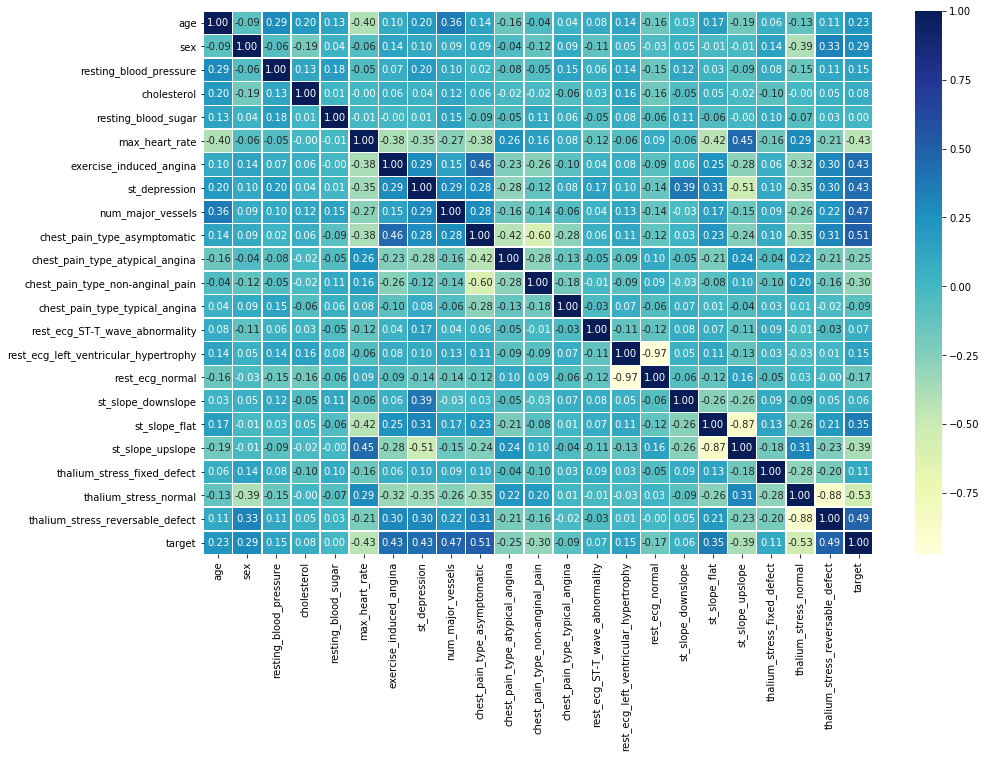

In [116]:
# Create a correlatin matrix across all features
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

There are some interesting observations across certain features which we'll explore more using our classifcation models:
1. Logistic Regression (classifier)
2. K-Nearest Neighbors classifier
3. Random Forest classifier

In [118]:
# Split the data into X and y
X = df.drop("target", axis=1)
y = df["target"]

# Split the data into training and test sets
np.random.seed(28)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2)
X_train.head()

,age,sex,resting_blood_pressure,cholesterol,resting_blood_sugar,max_heart_rate,exercise_induced_angina,st_depression,num_major_vessels,chest_pain_type_asymptomatic,...,chest_pain_type_typical_angina,rest_ecg_ST-T_wave_abnormality,rest_ecg_left_ventricular_hypertrophy,rest_ecg_normal,st_slope_downslope,st_slope_flat,st_slope_upslope,thalium_stress_fixed_defect,thalium_stress_normal,thalium_stress_reversable_defect
148,44,1,120,226,0,169,0,0.0,0,0,...,0,0,0,1,0,0,1,0,1,0
182,61,0,130,330,0,169,0,0.0,0,1,...,0,0,1,0,0,0,1,0,1,0
79,58,1,105,240,0,154,1,0.6,0,0,...,0,0,1,0,0,1,0,0,0,1
136,60,0,120,178,1,96,0,0.0,0,0,...,0,0,0,1,0,0,1,0,1,0
116,41,1,130,214,0,168,0,2.0,0,0,...,0,0,1,0,0,1,0,0,1,0


**Baseline Models**

In [119]:
# Create dictionary of models to be used
models = {"Logistic Regression" : LogisticRegression(),
          "KNN" : KNeighborsClassifier(),
          "Random Forest" : RandomForestClassifier()}

# Create a function that fits and scores the data to a given model
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and scores the given machine learning model to the training and testing data sets.
    
    models : a dictionary of different machine learning models
    X_train : the training data set (no labels)
    X_test : the test data set (no labels)
    y_train : the training labels
    y_test : the testing labels
    """
    # Set random seed
    np.random.seed(28)
    # Make an empty dictionary to save the scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and save it to model_score
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

# Evaluate baseline models
model_scores = fit_and_score(models = models,
                             X_train = X_train,
                             X_test = X_test,
                             y_train = y_train,
                             y_test = y_test)
model_scores

C:\Users\Alex\Desktop\machine_learning\heart_disease_project\env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'Logistic Regression': 0.8666666666666667,
 'KNN': 0.6166666666666667,
 'Random Forest': 0.8166666666666667}

**Hyperparameter Tuning - GridSearchCV**

In [124]:
np.random.seed(28)

# Create a hyperparameter grid for LogisticRegression
lr_grid = {"C" : np.logspace(-4, 4, 20),
                "solver" : ["liblinear"],
                "penalty" : ['l1', 'l2', 'elasticnet', 'none']}

# Create a hyperparameter grid for KNN
knn_grid = {"n_neighbors" : np.arange(1, 25, 1),
            "weights" : ['uniform', 'distance']}

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators" : np.arange(10, 1000, 50),
           "max_depth" : [None, 2, 3, 5, 10],
           "max_features" : [None, 'auto'],
           "min_samples_split" : np.arange(1, 20, 2),
           "min_samples_leaf" : np.arange(1, 20, 2)}

In [127]:
# Logistic Regression - 5 fold cross-validation 
np.random.seed(28)

# Create a hyperparameter grid for LogisticRegression
lr_grid = {"C" : np.logspace(-4, 4, 20),
                "solver" : ["liblinear"],
                "penalty" : ['l1', 'l2', 'elasticnet', 'none']}

# Setup random hyperparameter search for LogisticRegression
gs_lr_model = GridSearchCV(LogisticRegression(),
                           param_grid=lr_grid,
                           cv=5,
                           verbose=True)

# Fit random hyperparameter search model to training data
gs_lr_model.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Alex\Desktop\machine_learning\heart_disease_project\env\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\Alex\Desktop\machine_learning\heart_disease_project\env\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
C:\Users\Alex\Desktop\machine_learning\heart_disease_project\env\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for th

C:\Users\Alex\Desktop\machine_learning\heart_disease_project\env\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\Alex\Desktop\machine_learning\heart_disease_project\env\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
C:\Users\Alex\Desktop\machine_learning\heart_disease_project\env\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver suppo

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-04, 2.6...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
      

In [131]:
gs_lr_model.best_params_

{'C': 0.23357214690901212, 'penalty': 'l2', 'solver': 'liblinear'}

In [126]:
gs_lr_model.score(X_test, y_test)

0.8666666666666667

In [132]:
# KNN - GridSearchCV with 5 fold cross-validation 
np.random.seed(28)

# Create a hyperparameter grid for KNN
knn_grid = {"n_neighbors" : np.arange(1, 25, 1),
            "weights" : ['uniform', 'distance']}

# Setup random hyperparameter search for LogisticRegression
gs_knn_model = GridSearchCV(KNeighborsClassifier(),
                           param_grid=knn_grid,
                           cv=5,
                           verbose=True)

# Fit random hyperparameter search model to training data
gs_knn_model.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    1.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [133]:
gs_knn_model.best_params_

{'n_neighbors': 14, 'weights': 'uniform'}

In [134]:
gs_knn_model.score(X_test, y_test)

0.6166666666666667

KNN achieved a maximum accuracy of 62%, which is almost 20% lower than other models, so it will be ignored.

In [164]:
# Random Forest Classifier - RandomizedSearchCV with 5 fold cross-validation 
np.random.seed(28)

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators" : [100, 200],
           "max_depth" : [None, 2, 3, 5, 10],
           "max_features" : [None, 'auto'],
           "min_samples_split" : np.arange(2, 10, 2),
           "min_samples_leaf" : np.arange(1, 10, 2)}

# Setup random hyperparameter search for RandomForestClassifier
rs_rf_model = RandomizedSearchCV(RandomForestClassifier(),
                                 param_distributions=rf_grid,
                                 cv=5,
                                 n_iter=20,
                                 verbose=True)

# Fit random hyperparameter search model to training data
rs_rf_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   35.4s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [165]:
rs_rf_model.best_params_

{'n_estimators': 200,
 'min_samples_split': 8,
 'min_samples_leaf': 9,
 'max_features': 'auto',
 'max_depth': 5}

In [166]:
rs_rf_model.score(X_test, y_test)

0.85

In [167]:
# Random Forest Classifier - GridSearchCV 5 fold cross-validation 
np.random.seed(28)

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators" : [200],
           "max_depth" : [None, 5],
           "max_features" : [None, 'auto'],
           "min_samples_split" : [2, 8],
           "min_samples_leaf" : [2, 8]}

# Setup random hyperparameter search for RandomForestClassifier
gs_rf_model = GridSearchCV(RandomForestClassifier(),
                           param_grid=rf_grid,
                           cv=5,
                           verbose=True)

# Fit random hyperparameter search model to training data
gs_rf_model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   34.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [168]:
gs_rf_model.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [169]:
gs_rf_model.score(X_test, y_test)

0.8

Based on cross-validated (Randomized and Grid) models, the best accuracy was achieved using:
    * LogisticRegression - accuracy 86.67%
    * RandomForestClassification - accuracy 85%

These models will be used to make predictions and then their results compared. 

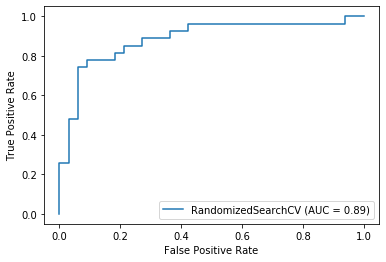

In [178]:
# Random Forest Classifier - ROC and AUC
y_preds_rf = rs_rf_model.predict(X_test)
plot_roc_curve(rs_rf_model, X_test, y_test);

In [182]:
print(classification_report(y_test, y_preds_rf))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        33
           1       0.88      0.78      0.82        27

    accuracy                           0.85        60
   macro avg       0.85      0.84      0.85        60
weighted avg       0.85      0.85      0.85        60



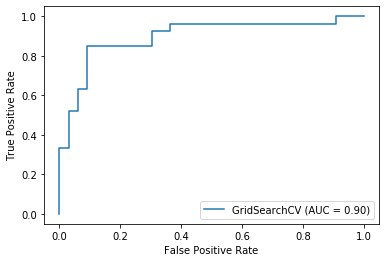

In [179]:
#Logistic Regression - ROC and AUC
y_preds_lr = gs_lr_model.predict(X_test)
plot_roc_curve(gs_lr_model, X_test, y_test);

In [183]:
print(classification_report(y_test, y_preds_lr))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88        33
           1       0.88      0.81      0.85        27

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60



The Logistic Regression model still performs better compared to the Random Forest Classifier and will thus be our model of choice.

**Feature Importance**

To better understand the model, we'll review the feature importance according to our best performing model.

In [187]:
clf = LogisticRegression(C = 0.23357214690901212, 
                         penalty = 'l2', 
                         solver = 'liblinear')
clf.fit(X_test, y_test)
perm = PermutationImportance(clf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0633 ± 0.0442,sex
0.0600 ± 0.0267,resting_blood_pressure
0.0433 ± 0.0499,num_major_vessels
0.0333 ± 0.0471,max_heart_rate
0.0300 ± 0.0249,thalium_stress_reversable_defect
0.0267 ± 0.0267,thalium_stress_normal
0.0167 ± 0.0211,chest_pain_type_non-anginal_pain
0.0133 ± 0.0249,chest_pain_type_asymptomatic
0.0033 ± 0.0133,exercise_induced_angina
0 ± 0.0000,chest_pain_type_atypical_angina


Interestingly, 'sex/gender' comes up as the most important feature, followed by 'resting blood pressure' and 'number of major vessels'. Whilst the latter two are likely more related, looking at the relationship between 'sex' and 'target' might give more insight.

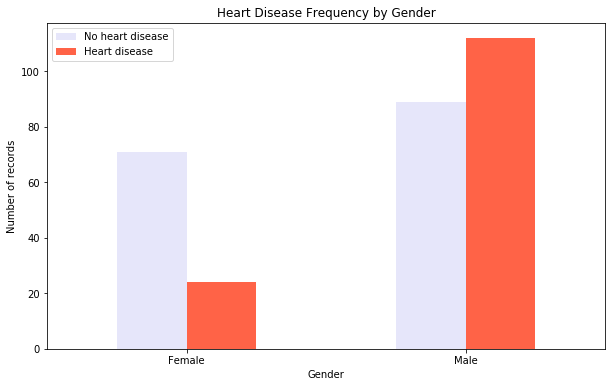

In [196]:
# Compare the feature variable 'sex' to the label 'target'
pd.crosstab(df["sex"], df["target"]).plot(kind = "bar",
                                          figsize = (10,6),
                                          color = ["lavender", "tomato"])
plt.title("Heart Disease Frequency by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of records")
plt.legend(["No heart disease", "Heart disease"])
plt.xticks(np.arange(0,2), labels=("Female", "Male"),rotation=0);

It is immediately clear that there is an imbalance with patients having heart disease are much more likely to be male, as opposed to female. For formal research purposes, these could be excluded or weighting lowered to further improve the model's accuracy on data it has not seen. However, based on the data supplied, the model has 'valid' gender-based bias.

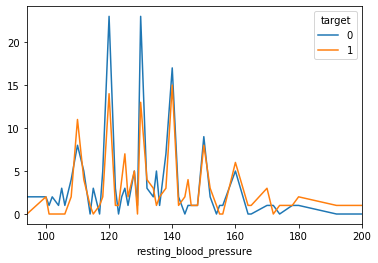

In [213]:
pd.crosstab(df["resting_blood_pressure"], df["target"]).plot();

In [204]:
df["sex"][df["sex"] == 1].count() / df["sex"].count()

0.6790540540540541